This notebook contains the Exploratory Data Analysis that will help guide the creation of our clustering models.  The data preprocessing steps included:  

(1) Removing URLs, non-alphabetic characters, and converting all words to lowercase  
(2) Removing stop words  
(3) Applying lemmatization (using NLTK's WordNet Lemmatizer) or stemming (using the Lancaster or Porter stemmers)  
(4) Removing stub words (usually endings of words that were contractions)  

Additionally, document embeddings were trained with the processed data (you can this process in the "Train Embeddings" notebook).  With data preprocessing completed, we can move on to exploring our dataset.  The dataset includes posts from 37 subreddits spanning 8 "categories" that were assigned by hand to establish ground-truth for clustering.  Note that these categories are broad, and there are only 4-5 subreddits represented for each category.  We begin by reading in comments from each represented subreddit; comment data was stored in .json format in the data collection and preprocessing phases.  Each comment has the following information:  

(1) Comment's unique ID  
(2) Parent post's unique ID  
(3) Comment text  

The first two fields are scraped to give credit to the original posters and commenters, but the comment text is the only data used for EDA and clustering.  The general outline of the EDA phase is as follows:  

(1) Explore TF-IDF vectorization for subs  
(2) Explore Count vectorization for subs  
(3) Visualize trained document-embeddings  
(4) Create word clouds for subs in each category  
(5) Visualize TF-IDF vectorization for each post  
(6) Visualize document-embeddings for each post

Note that all visualizations are done with the lemmatized comment data, since stemmers have a tendency to produce reductions that are not actual words.

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

%matplotlib inline

## Exploring with the Lemmatizer

**Create Documents**

We begin by reading in the comment data for each subreddit:

In [2]:
cats = ['art', 'gaming', 'music', 'politics_news', 'reading', 'science', 'sports', 'tech']
stem = 'lemma'

In [3]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

We may also want to label encode the category of each document:

In [4]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])
documents[:, 2]

array(['0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '2', '2', '2',
       '2', '2', '3', '3', '3', '3', '4', '4', '4', '4', '4', '5', '5',
       '5', '5', '5', '6', '6', '6', '6', '7', '7', '7', '7', '7'],
      dtype='<U1716906')

In [5]:
encoder.inverse_transform(np.array(documents[:, 2], dtype=int))

array(['art', 'art', 'art', 'art', 'art', 'gaming', 'gaming', 'gaming',
       'gaming', 'gaming', 'music', 'music', 'music', 'music', 'music',
       'politics_news', 'politics_news', 'politics_news', 'politics_news',
       'reading', 'reading', 'reading', 'reading', 'reading', 'science',
       'science', 'science', 'science', 'science', 'sports', 'sports',
       'sports', 'sports', 'tech', 'tech', 'tech', 'tech', 'tech'],
      dtype='<U1716906')

**Create Document Vectors**

We should explore using both the tf-idf- and count-vectorizers; we should also look at different combinations of ngrams (let's use 1-grams, 1- and 2-grams, and 1- and 2- and 3-grams).

**TF-IDF Vectorizer**

Let's start by just looking at 1-grams:

In [6]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()  # default n_components=2 for plotting

X = svd.fit_transform(X)

In [7]:
def get_label(i, colors, documents):
    """
    The get_label function helps plot one label per category.  Probably could find an easier way to do it, but this way
    worked for me when I was starting the project.
    """
    if colors[documents[i][1]][1] == 0:
        colors[documents[i][1]][1] += 1
        return documents[i][1]
    else:
        return ""

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-grams')

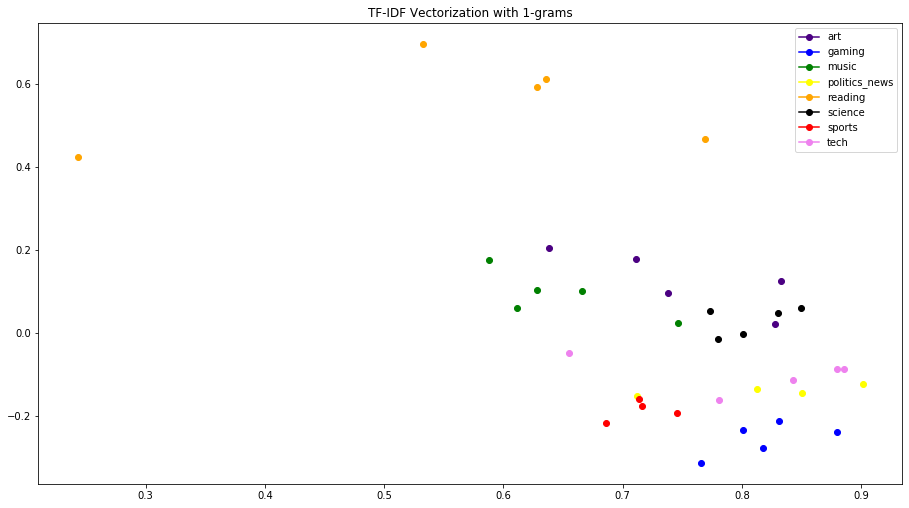

In [8]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-grams')

There are some interesting patterns here.  There is a very clear clustering along the bottom for gaming subreddits, and a very clear clustering for the reading subreddits at the top.  The rest are a bit harder to find clear clusters for.  Note, for example, that politics/news subreddits and tech subreddits have some overlap; likewise, music and art subreddits are closely linked.  In a future project, I might want to exclude posts that have been cross-posted (often written x-posted) from one sub to another.  It's highly likely that posts from tech subreddits would also get posted on r/news, or even that tech and science subreddits have a lot of shared crossposts.  Let's repeat the process, this time using 1- and 2-grams:

In [9]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'TF-IDF Vectorization with 1- and 2-grams')

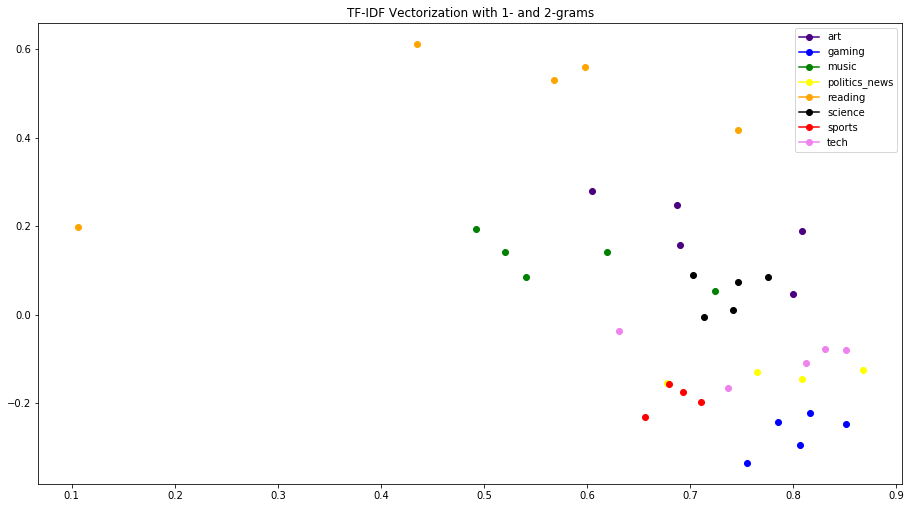

In [10]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1- and 2-grams')

There's not a lot of difference here, but it does produce some larger distances between individual subs (even within categories).  For example, notice how a lot of the usic subreddits grew farther apart than before.  I don't end up using these vectorizations, but it would be very interesting to see how using n-gram ranges would impact a clustering.  Finally, let's repeat the process but using 1-, 2-, and 3-grams:

In [11]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-, 2-, and 3-grams')

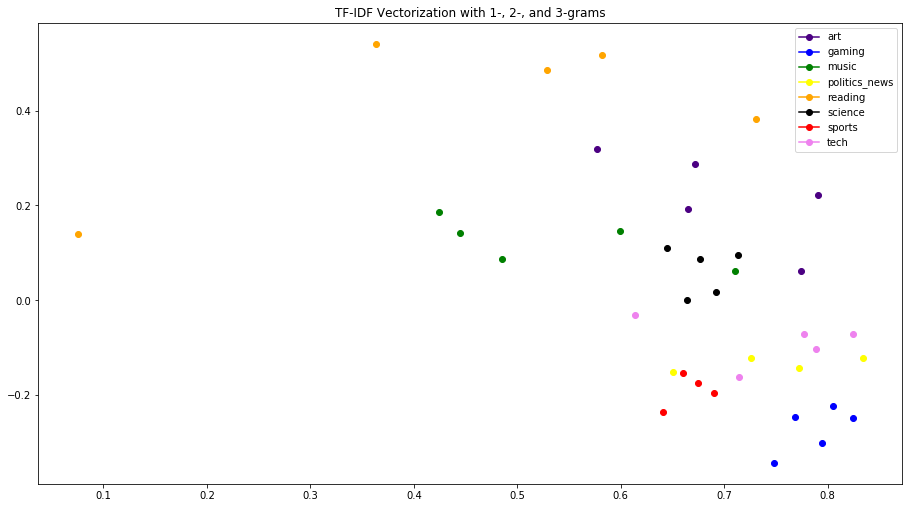

In [12]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-, 2-, and 3-grams')

Again, there are subtle differences with this vectorization, but I don't think they're significant enough to really explore in depth.

**Count Vectorizer**

The TF-IDF vectorizor weights each item in the term-document matrix using the "rarity" of that word in the total corpus.  For example, a word that appears a large number of times in one subreddit but rarely in the entire corpus gets weighted very highly.  This helps to highlight the specialty of each subreddit.  However, one can also use a count vectorizer that doesn't weight by rarity.  Instead, the weight in the matrix is just the number of times that word appears in the document.  Let's explore, starting with just 1-grams:

In [13]:
count_vectorizer = CountVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = count_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'Count Vectorization with 1-grams')

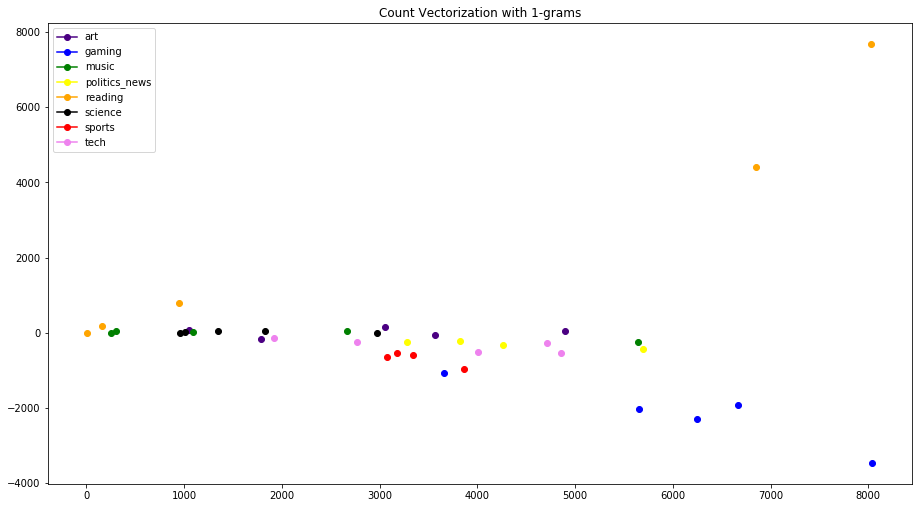

In [14]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Count Vectorization with 1-grams')

We can see that this vectorization does not produce very many distinct clusters!  As such, we would probably have better luck using the TF-IDF vectorizer when we make a clustering model.  Nonetheless, let's keep exploring by looking at 1- and 2-grams:

Text(0.5, 1.0, 'Count Vectorization with 1- and 2-grams')

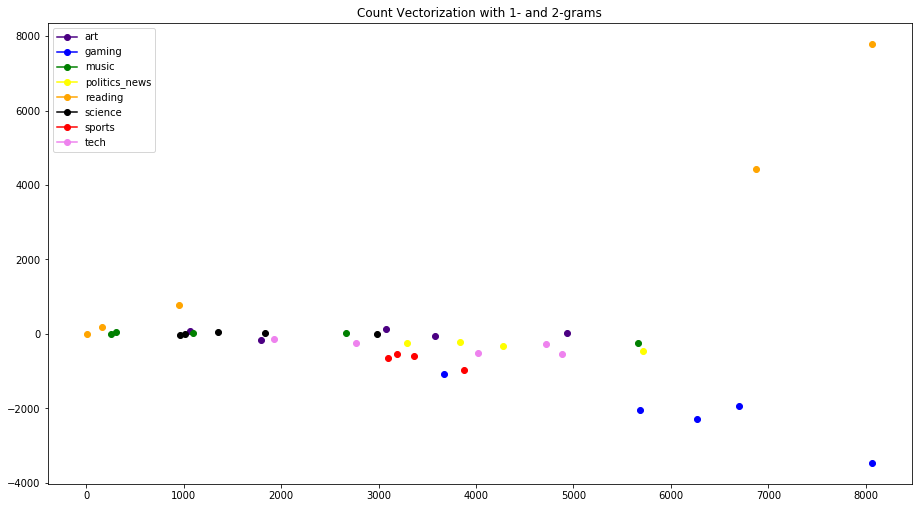

In [15]:
count_vectorizer = CountVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2))
X = count_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Count Vectorization with 1- and 2-grams')

Not a very significant change at all.  Let's now look at using 1-, 2-, and 3-grams:

Text(0.5, 1.0, 'Count Vectorization with 1-, 2-, and 3-grams')

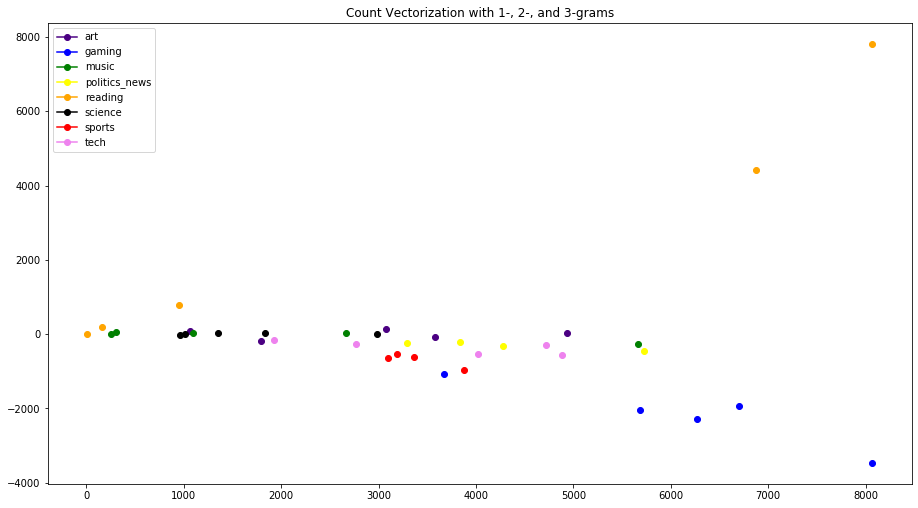

In [16]:
count_vectorizer = CountVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
X = count_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Count Vectorization with 1-, 2-, and 3-grams')

Once again, not a big improvement in producing distinct clusters.  We should definitely stick to using a TF-IDF vectorization in our clustering models!

## Visualizing Word Embeddings

A significant drawback of using an TF-IDF vectorizer is that it produces huge, sparse matrixes.  Since every term in the corpus has to be represented, this is both computationally and memory intensive.  It also severely limits the number of models that we can train on our dataset (for example, only sklearn's K-Means supports sparse matrix inputs).  Finally, it means that for building models we have to use SVD decomposition, and treat the number of components as a parameter that needs to be tuned for our models.  This is a lot of work and I'm not an expert on the ideal number of dimensions to reduce to for text clustering.  Instead, we can train document embeddings on our dataset to obtain a numerical representation of every subreddit.  See the "Train Embeddings" script for an exploration of this process.  

Since the reading subreddits have very little in the way of comments, our trained embeddings do not include them.  In the end, I trained 4-dimensional document embeddings on the corpus.  Let's explore how they cluster:

In [17]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

Since reading subs aren't included in our document embeddings, let's go ahead and pop that out of our cats list:

In [18]:
cats.remove('reading')

Now let's read in our subreddit data again:

In [19]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [20]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

Now let's load our pre-trained models and store them in an array called doc_vectors.  We'll use PCA decomposition to get the document vectors in two-dimensions for plotting:

In [21]:
os.chdir(r'C:\Users\jonat\Desktop\Data Mining\Project\Data')

model = Doc2Vec.load('subs.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)
labels = np.array(documents[:, 2], dtype=int)

Text(0.5, 1.0, 'Document Embeddings for Subreddits')

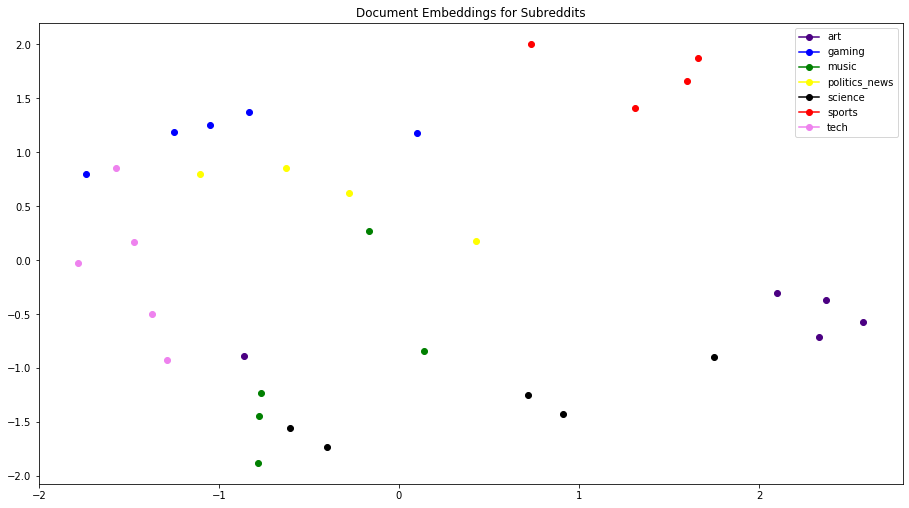

In [22]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Document Embeddings for Subreddits')

This produces some pretty clear clusters!  The ease of use of the document embeddings also makes it a powerful representation of each subreddit.

## Word Clouds

Another way to visualize text data is with word clouds.  I'll use the Python [wordcloud](http://amueller.github.io/word_cloud/) package and generate word clouds for each subreddit by category.

In [23]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

**The art subreddits:**

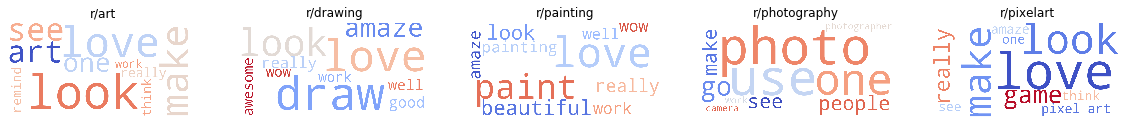

In [24]:
art_subs = documents[documents[:, 1] == 'art']

fig, ax = plt.subplots(ncols=len(art_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(art_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{art_subs[i][3]}')

You can already see some clear patterns in this category.  The words "love", "make", and "look" are pretty universal.  Each subreddit also has some unique terms, like "photo" for r/photography and "pixel art" for r/pixelart.

**The gaming subreddits:**

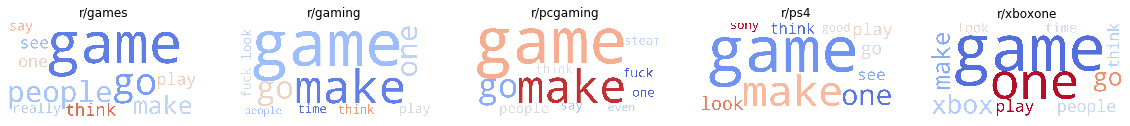

In [25]:
gaming_subs = documents[documents[:, 1] == 'gaming']

fig, ax = plt.subplots(ncols=len(gaming_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(gaming_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{gaming_subs[i][3]}')

Every gaming subreddit has the word "game," and most have words like "make," and "play."  Profanity is also prevalent.

**The music subreddits:**

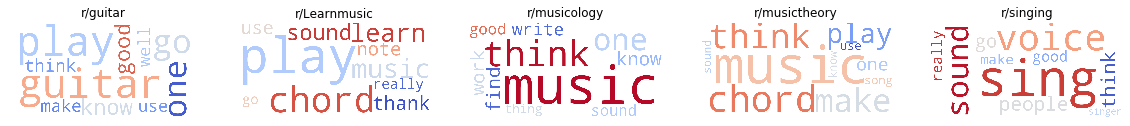

In [26]:
music_subs = documents[documents[:, 1] == 'music']

fig, ax = plt.subplots(ncols=len(music_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(music_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{music_subs[i][3]}')

These subs have a lot of "play," which might bring them closer to the gaming subreddits.  There is also a lot of specialized terminology within each sub.

**The politics/news subreddits:**

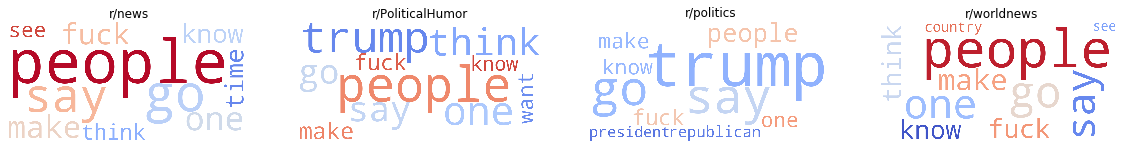

In [27]:
politics_news_subs = documents[documents[:, 1] == 'politics_news']

fig, ax = plt.subplots(ncols=len(politics_news_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(politics_news_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{politics_news_subs[i][3]}')

The word "people" is really common in the politics/news subreddits.  There is also a lot of profanity, and US-specific political terms like "republican" and "trump."  The word "know" is also pretty common, which makes me think that politics/news users are pretty full of themselves.

**The sports subreddits**:

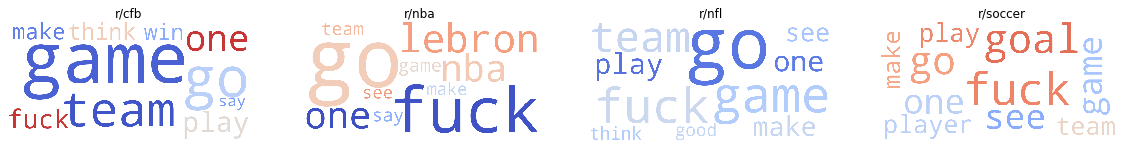

In [29]:
sports_subs = documents[documents[:, 1] == 'sports']

fig, ax = plt.subplots(ncols=len(sports_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(sports_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{sports_subs[i][3]}')

All of these subs have a lot of profanity (namely, the f-word).  The words "go", "game", and "team" are also pretty common.  This might bring them closer to the gaming subreddits.

**The science subreddits:**

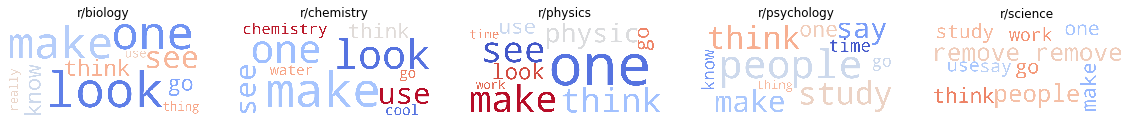

In [30]:
science_subs = documents[documents[:, 1] == 'science']

fig, ax = plt.subplots(ncols=len(science_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(science_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{science_subs[i][3]}')

This one is a really mixed bag, probably brought about by the specific field of each subreddit.  "Study" is pretty common in both r/psychology and r/science, but isn't used as much in the other science subs.  r/science also heavily features "remove," indicating comments that have been removed.

**The tech subreddits**

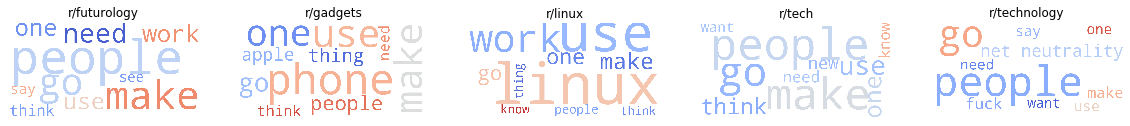

In [31]:
tech_subs = documents[documents[:, 1] == 'tech']

fig, ax = plt.subplots(ncols=len(tech_subs), figsize=[20, 20])

for i, axis in enumerate(ax):
    wordcloud = WordCloud(max_words=10, background_color='white', width=1000, height=500, colormap='coolwarm').generate(tech_subs[i][0])
    axis.imshow(wordcloud)
    axis.axis("off")
    axis.set_title(f'r/{tech_subs[i][3]}')

"People" is shared across all of these subs, as well as specific terms in each subreddit like "linux," "phone," "apple," and "net neutrality."

**You can use the script generate_visualizations.py to create all combinations of n-grams and stemming, as well as word clouds.**

## Exploring Posts

Finally, let's explore the text data grouped by post rather than subreddit:

In [37]:
cats.append('reading')

In [38]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [39]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

We'll start by looking at the tf-idf vectorized posts:

In [40]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X = svd.fit_transform(X)

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-grams')

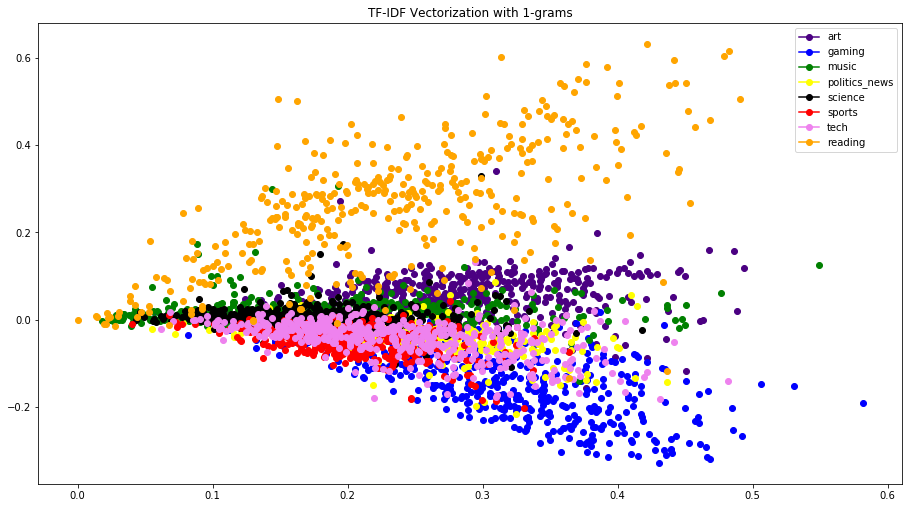

In [41]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-grams')

These groupings look roughly linear, but many clustering algorithms favor globular shapes.  There's also a massive amount of overlap towards the center, which will make clustering very difficult.

**Using document embeddings**

Now let's explore using our pre-trained document embeddings:

In [42]:
cats.remove('reading')

In [43]:
documents = []

for cat in cats:
    os.chdir(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'C:\Users\jonat\Desktop\Data Mining\Project\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [44]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [45]:
os.chdir(r'C:\Users\jonat\Desktop\Data Mining\Project\Data')

model = Doc2Vec.load('posts.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)

Text(0.5, 1.0, 'Document Embeddings for Subreddits')

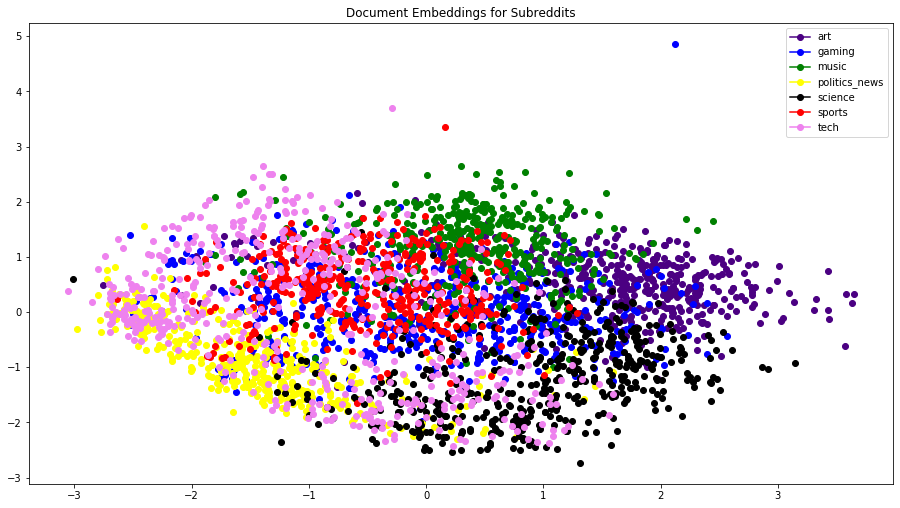

In [46]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('Document Embeddings for Posts')

Again, there are some clear groupings but massive overlap!  Clustering will be very hard for posts, but we should still try and see what we end up getting.  It's clear that a clustering of subreddits alone will be much more effective, but generating post recommendations is also a very useful task.  We'll see what we can do in each case!